In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

# (1) Picture acquisition

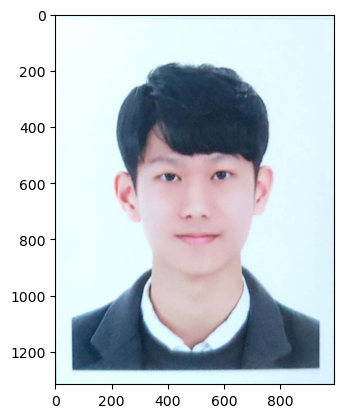

In [2]:
my_image_path = '/Users/Kim/Desktop/AIFFEL/Submission.png'
img_bgr = cv2.imread(my_image_path)

# Convert BGR image to RGB format
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img_show = img_rgb.copy()

# Display the image
plt.imshow(img_rgb)
plt.show()

# Reading BGR image doesn't work fluently with the method "plt.imshow"
# --> Converted the BGR image to RGB format and displayed the image.

# Face Detection & Landmark Detection

    Utilize the dlib library to find the bounding box position of the face and the positions of facial landmarks.

In [3]:
detector_hog = dlib.get_frontal_face_detector()

dlib_rects = detector_hog(img_rgb, 1)

print(dlib_rects)

# Designating the domain of the face

rectangles[[(290, 504) (675, 889)]]


In [4]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left() # left
    t = dlib_rect.top() # top
    r = dlib_rect.right() # right
    b = dlib_rect.bottom() # bottom

# Assigining the point of each respectively

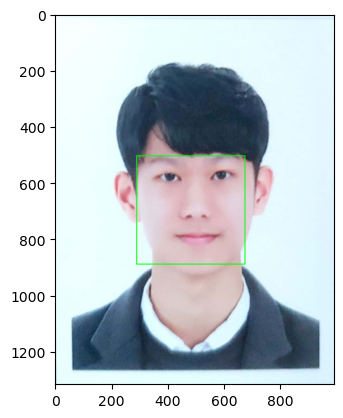

In [5]:
cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType = cv2.LINE_AA)

plt.imshow(img_show)
plt.show()

In [6]:
model_path = '/Users/Kim/Downloads/shape_predictor_68_face_landmarks.dat'

landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

# Dlib landmark localization with "dlib.shape_predictor"

68


# Check the Location for Sticker Application:

    Use facial landmarks to calculate a position for applying the cat's mustache sticker. 
    
    It is expected to find a position better than the tip of the nose, which is landmark number 33.



#### Object keypoint estimation algorithm

The technique of identifying points within an object, such as face landmarks, is referred to as object keypoint estimation.

The algorithms for keypoint estimation can be broadly categorized into two approaches:

    1. Top-down: First, a bounding box is detected, and then keypoints within the box are predicted.

    2. Bottom-up: Keypoints are initially detected across the entire image, and then clustering is applied using the relationships between the points to generate bounding boxes.

In the provided example, the top-down approach was utilized.


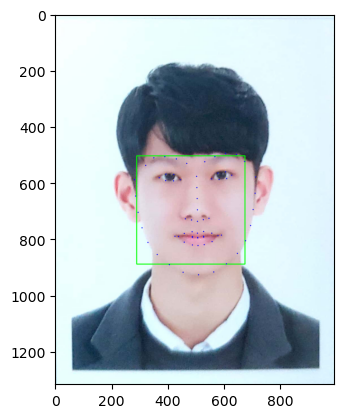

In [7]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0,0,255), -1)
        
plt.imshow(img_show)

plt.show()

In [8]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[32])
    x = landmark[32][0]
    y = int(landmark[30][1] + (landmark[33][1] - landmark[30][1]) / 3)
    w = h = dlib_rect.width()
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')
    
# Assigning the midpoint of the nose to the variable x and y
# Assigning the width of the original image to the variable w and h
# To accurately determine the midpoint of the nose, I made adjustments to the variable 'y'

#-------------------------------------------------------------------------

# for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
#     print(landmark[32])
#     x = landmark[32][0]
#     y = landmark[32][1] - dlib_rect.height()//2
#     w = h = dlib_rect.width()
#     print (f'(x,y) : ({x},{y})')
#     print (f'(w,h) : ({w},{h})')

# The codes below are the one before the adjustment of variable 'y'


(485, 732)
(x,y) : (485,709)
(w,h) : (386,386)


# Apply the Sticker
    
    (1) Apply the sticker using np.where
    
    (2) make the original image visible behind the sticker. 
    
    Refer to cv2.addWeighted() from the OpenCV library.

In [9]:
sticker_path = '/Users/Kim/Desktop/AIFFEL/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(386, 386, 3)


In [10]:
refined_x = x - w // 2 + 20
refined_y = y - h // 2

print(f'(refined_x, refined_y): ({refined_x},{refined_y})')

# The code was iteratively executed to observe the applied location of the sticker, 
# and the refined values of refined_x and refined_y were adjusted manually for experimentation purposes.

(refined_x, refined_y): (312,516)


In [11]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

# An exception handling was implemented to account for cases 
# where the values of refined_x and refined_y become negative, 
# indicating that the sticker area extends beyond the boundaries of the original image.


(x,y) : (312,516)


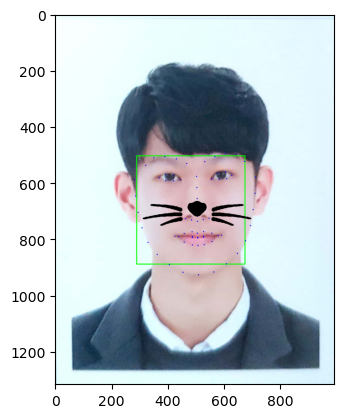

In [12]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# Create a mask of the sticker region
img_sticker_gray = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
_, sticker_mask = cv2.threshold(img_sticker_gray, 1, 255, cv2.THRESH_BINARY_INV)

# Create an inverse mask for the sticker region
sticker_mask_inv = cv2.bitwise_not(sticker_mask)

# Apply the inverse mask to the sticker area
background = cv2.bitwise_and(sticker_area, sticker_area, mask=sticker_mask_inv)

# Apply the sticker to the image
foreground = cv2.bitwise_and(img_sticker, img_sticker, mask=sticker_mask)
sticker_added = cv2.addWeighted(background, 1, foreground, 1, 0)

# Replace the sticker area with the sticker-added region
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = sticker_added.astype(np.uint8)

plt.imshow(img_show)
plt.show()

# ------------------------------------------------------------------------------------------------------------------------------

# 노드의 코드 에서 np.where의 인자 중 img_sticker, sticker_area 위치를 바꿨다.
# sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    # np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

# plt.imshow(img_show)
# plt.show()

# ------------------------------------------------------------------------------------------------------------------------------

# 노드의 코드에서 img_sticker == 0을 255로 바꿔주었다.
# = 스티커가 들어갈 위치에 스티커에서 255인 부분(흰색 부분)을 모두 crop된 이미지로 대체한다.
# sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    # np.where(img_sticker==255,img_sticker,sticker_area).astype(np.uint8)

# plt.imshow(img_show)
# plt.show()

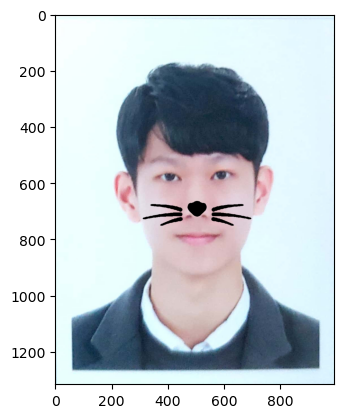

In [13]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_sticker_gray = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2GRAY)
_, sticker_mask = cv2.threshold(img_sticker_gray, 1, 255, cv2.THRESH_BINARY_INV)

sticker_mask_inv = cv2.bitwise_not(sticker_mask)

background = cv2.bitwise_and(sticker_area, sticker_area, mask=sticker_mask_inv)

foreground = cv2.bitwise_and(img_sticker, img_sticker, mask=sticker_mask)
sticker_added = cv2.addWeighted(background, 1, foreground, 1, 0)

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = sticker_added.astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# Modifying variable to be applied from "img_show" to "img_bgr"

# ------------------------------------------------------------------------------------------------------------------------------

# sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    # np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

# plt.imshow(img_bgr)
# plt.show()

# ------------------------------------------------------------------------------------------------------------------------------

# sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    # np.where(img_sticker==255,img_sticker,sticker_area).astype(np.uint8)

# plt.imshow(img_bgr)
# plt.show()

# Identify Issues
   
For example,    
   
    (1) Capture self-camera footage from various angles and apply the sticker repeatedly.

    (2) Document the issues as precisely as possible. There are undoubtedly solutions to the issues you have identified!

#### Actual Issues    
    
    1. Accurately determining the exact midpoint of the nose using the provided landmark predictor proved to be challenging. This issue directly impacted the precise alignment of the sticker to the nose's location.
    
    2. Achieving transparency in the background of the sticker image.
    
    3. Ensuring that the target object (the cat mustache sticker) appears black and opaque.  

# Potential issues to consider in the sticker app developed today

* How should the sticker change depending on the angle of the face?


* Why doesn't it work when capturing from a distance? Why doesn't it work when lying down and capturing from the side?


* Is execution speed crucial?


* How important is accuracy when creating a sticker app?